# Dump Leakage Calorimeter

## Imports and Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit, root
from scipy.constants import elementary_charge
from scipy.odr import ODR, Model, RealData

from mpl_toolkits.axes_grid1 import make_axes_locatable

from helperFunctions import *

In [2]:
# plot settings, increase font sizes
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.labelspacing'] = 0.2

In [3]:
def chargeFct (p, x):
    return p[3] * ( p[2]*x**2 + p[1]*x + p[0] )

## Beamspot

In [4]:
# camera calibration in [mm/px]
camXconv = 10.8 / 1e3
camYconv = 11.4 / 1e3

# load the preprocessed camera data
bg_roi = np.load('processed/cameraBeamspot.npz')['bg_roi']
cam_roi = np.load('processed/cameraBeamspot.npz')['cam_roi']

# subtract the background from the signal
cam_roi -= bg_roi

# calculate the projection to the horizontal and vertical axes
cam_py = cam_roi.mean(axis=1)
cam_px = cam_roi.mean(axis=0)

# calculate the FWHM in both directions
print('FWHM')
print(f'X: {camXconv*np.sum(cam_px>cam_px.max()/2):.1f} mm')
print(f'Y: {camYconv*np.sum(cam_py>cam_py.max()/2):.1f} mm')

FWHM
X: 0.2 mm
Y: 0.6 mm


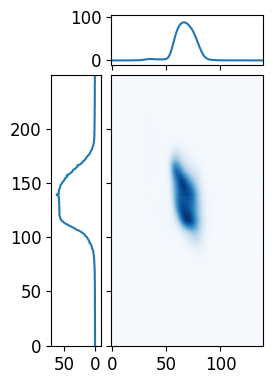

In [5]:
fig, ax = plt.subplots(figsize=(4,4))

# the scatter plot:
cax = ax.imshow(cam_roi, origin='lower', cmap='Blues')
#fig.colorbar(cax)

# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.5, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("left", 0.5, pad=0.1, sharey=ax)

# make some labels invisible
ax.yaxis.set_tick_params(labelleft=False)
ax_histx.xaxis.set_tick_params(labelbottom=False)
#ax_histy.yaxis.set_tick_params(labelleft=False)

ax_histx.plot(np.arange(len(cam_px)), cam_px)
ax_histx.set(ylim=(-10, 105))

ax_histy.plot(cam_py, np.arange(len(cam_py)))
ax_histy.set(xlim=(70,-10))

fig.tight_layout()

plt.show()

## Position

In [6]:
nCH = 2
channels = [2,6]

In [7]:
# measurement from horizontal scan
runs = np.array([4, 5, 6, 7, 8])

posX = np.zeros((2, len(runs)))
posY = np.zeros((2, len(runs)))
charge = np.zeros(0)

sig = np.zeros((nCH, 2, len(runs)))

for r,run in enumerate(runs):

    posX[:,r] = meanWithError(getDOOCS(run, 'posX'))
    posY[:,r] = meanWithError(getDOOCS(run, 'posY'))
    charge = np.append(charge, getDOOCS(run, 'charge'))
    
    for c,ch in enumerate(channels):
        sig[c,:,r] = meanWithError(getCALO(run, ch, 'int'))

bunch charge: (99 +/- 1) pC


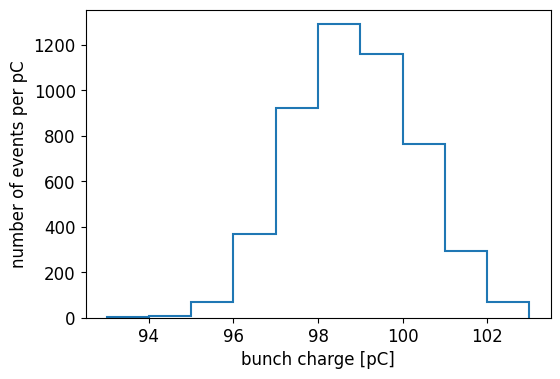

In [8]:
print(f'bunch charge: ({charge.mean():.0f} +/- {charge.std():.0f}) pC')

bins = np.arange(np.floor(charge.min()),np.ceil(charge.max()), 1)

fig, ax = plt.subplots()
ax.hist(charge, bins, histtype='step', lw=1.5)
ax.set(xlabel='bunch charge [pC]', ylabel='number of events per pC')
plt.show()

CH2
(3.74 +/- 0.03) mV×µs/mm
position precision: 15 µm

CH6
(-3.69 +/- 0.09) mV×µs/mm
position precision: 39 µm

Mean 2/6
(0.02 +/- 0.04) mV×µs/mm


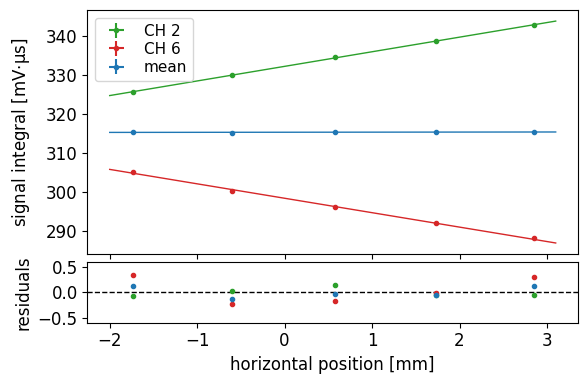

In [9]:
posXFit = np.linspace(-2, 3.1)

with plt.rc_context(regu):

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[4,1]})
    
    for i,ch in enumerate([2,6]):

        odrOutput = ODR(RealData(x=posX[0], y=sig[i,0], sy=sig[i,1], sx=posX[1]), Model(linFct), beta0=[1.,1.]).run()
        popt = odrOutput.beta; perr = odrOutput.sd_beta
        
        print(f'CH{ch}')
        print(f'({popt[1]:.2f} +/- {perr[1]:.2f}) mV×µs/mm')

        N = 10000
        a = np.random.normal(popt[1], perr[1], N)
        b = np.random.normal(popt[0], perr[0], N)
        y = np.random.normal((linFct(popt, 0)), sig[i,1].mean(), N)
        x = (y-b)/a
        print(f'position precision: {1e3*x.std():.0f} µm\n')
        
        ax[0].errorbar(posX[0], *sig[i], posX[1], fmt=f'C{i+2}.', label=f'CH {ch}')
        ax[0].plot(posXFit, linFct(popt, posXFit), f'C{i+2}', lw=1)
        ax[1].errorbar(posX[0], sig[i][0]-linFct(popt, posX[0]), sig[i][1], posX[1], fmt=f'C{i+2}.')

    chmn = [0,1]
    mn = (sig[chmn[0],0]+sig[chmn[1],0])/2, np.sqrt(sig[chmn[0],1]**2+sig[chmn[1],1]**2)/2

    odrOutput = ODR(RealData(x=posX[0], y=mn[0], sy=mn[1], sx=posX[1]), Model(linFct), beta0=[1.,1.]).run()
    popt = odrOutput.beta; perr = odrOutput.sd_beta
    
    print(f'Mean {channels[0]}/{channels[1]}')
    print(f'({popt[1]:.2f} +/- {perr[1]:.2f}) mV×µs/mm')
    
    ax[0].errorbar(posX[0], *mn, posX[1], fmt='C0.', label='mean')
    ax[0].plot(posXFit, linFct(popt, posXFit), 'C0', lw=1)
    ax[1].errorbar(posX[0], mn[0]-linFct(popt, posX[0]), mn[1], posX[1], fmt='C0.')

    ax[1].axhline(0, c='C5', ls='--', lw=1)

    ax[0].legend()
    ax[0].set(ylabel=r'signal integral [mV$\cdot$µs]')
    ax[1].set(xlabel='horizontal position [mm]', ylabel='residuals', ylim=(-0.6, 0.6))

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    fig.align_ylabels(ax)
    
    plt.show()

## Charge Calibration

In [10]:
# sampling time in [ns]
samplingTime = 2

# number of channels and channel array
nPMT = 8
chPMT = np.arange(nPMT)

nSC = 4
chSC = np.arange(nSC) + 8

nALL = nPMT+nSC
chALL = np.concatenate((chPMT,chSC))

# number of samples taken
nSamples = 1000

# radial position of the calorimeter rods in [mm]
R = 161

# define the positions of the calorimeter rods in polar coordinates in [mm,rad]
positions_polar = np.array([np.repeat(R, nPMT), 
                            -np.pi/4*np.arange(nPMT)+np.pi/2]).T

# calculate the positions of the calorimeter rods in cartesian coordinates in [mm,mm]
positions_cartesian = np.array([positions_polar[:,0]*np.cos(positions_polar[:,1]),
                                positions_polar[:,0]*np.sin(positions_polar[:,1])]).T

### Method Comparison

In [11]:
runs = [219, 220, 222, 223, 224, 225, 227]

charges = np.zeros((2, len(runs)))
amplitude = np.zeros((nPMT, 2, len(runs)))
integral = np.zeros((nPMT, 2, len(runs)))
tot = np.zeros((nPMT, 2, len(runs)))

for r,run in enumerate(runs):

    charges[:,r] = meanWithError(getDOOCS(run))
    
    for ch in chPMT:
        amplitude[ch,:,r] = meanWithError(getCALO(run, ch, 'amp'))
        integral[ch,:,r] = meanWithError(getCALO(run, ch, 'int'))
        tot[ch,:,r] = meanWithError(getCALO(run, ch, 'tot'))

chmn = [2,6]
amplitude = np.array([(amplitude[chmn[0],0]+amplitude[chmn[1],0])/2, np.sqrt(amplitude[chmn[0],1]**2+amplitude[chmn[1],1]**2)/2])
integral = np.array([(integral[chmn[0],0]+integral[chmn[1],0])/2, np.sqrt(integral[chmn[0],1]**2+integral[chmn[1],1]**2)/2])
tot = np.array([(tot[chmn[0],0]+tot[chmn[1],0])/2, np.sqrt(tot[chmn[0],1]**2+tot[chmn[1],1]**2)/2])

curvature: -1.59 ± 0.34 (residual variance: 1321)
curvature: -0.61 ± 0.06 (residual variance: 32)
curvature: +0.40 ± 0.09 (residual variance: 113)


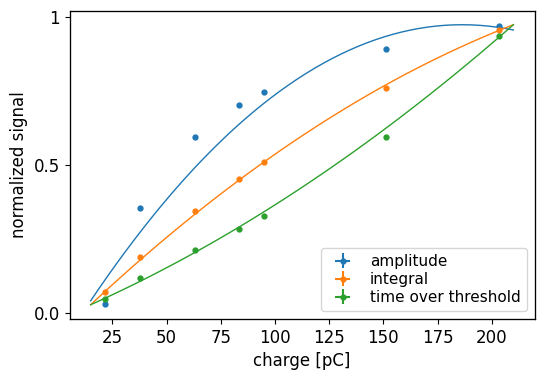

In [12]:
chargesFit = np.linspace(15, 210)

with plt.rc_context(regu):

    fig, ax0 = plt.subplots()

    ax1 = ax0.twinx()
    ax2 = ax0.twinx()
    ax1.get_yaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    odrOutput = ODR(RealData(x=charges[0], y=amplitude[0], sy=amplitude[1], sx=charges[1]), Model(chargeFct), beta0=[1.,1.,1.,1.], ifixb=[1,1,1,0]).run()
    popt = odrOutput.beta; perr = odrOutput.sd_beta
    ax0.errorbar(charges[0], *amplitude, charges[1], fmt='C0.', ms=7, label='amplitude')
    ax0.errorbar(chargesFit, chargeFct(popt, chargesFit), fmt='C0-', lw=1)
    print(f'curvature: {1e3*popt[2]:+.2f} ± {1e3*perr[2]:.2f} (residual variance: {odrOutput.res_var:.0f})')
    
    odrOutput = ODR(RealData(x=charges[0], y=integral[0], sy=integral[1], sx=charges[1]), Model(chargeFct), beta0=[1.,1.,1.,1.], ifixb=[1,1,1,0]).run()
    popt = odrOutput.beta; perr = odrOutput.sd_beta
    ax1.errorbar(charges[0], *integral, charges[1], fmt='C1.', ms=7)
    ax1.errorbar(chargesFit, chargeFct(popt, chargesFit), fmt='C1-', lw=1)
    ax0.errorbar(np.nan, np.nan, np.nan, np.nan, fmt='C1.', ms=7, label='integral')
    print(f'curvature: {1e3*popt[2]:+.2f} ± {1e3*perr[2]:.2f} (residual variance: {odrOutput.res_var:.0f})')

    odrOutput = ODR(RealData(x=charges[0], y=tot[0], sy=tot[1], sx=charges[1]), Model(chargeFct), beta0=[1.,1.,1.,1.], ifixb=[1,1,1,0]).run()
    popt = odrOutput.beta; perr = odrOutput.sd_beta
    ax2.errorbar(charges[0], *tot, charges[1], fmt='C2.', ms=7)
    ax2.errorbar(chargesFit, chargeFct(popt, chargesFit), fmt='C2-', lw=1)
    ax0.errorbar(np.nan, np.nan, np.nan, np.nan, fmt='C2.', ms=7, label='time over threshold')
    print(f'curvature: {1e3*popt[2]:+.2f} ± {1e3*perr[2]:.2f} (residual variance: {odrOutput.res_var:.0f})')

    ax0.legend(loc='lower right')
    ax0.set(xlabel='charge [pC]', ylabel='normalized signal')

    ylim = ax0.get_ylim()
    ax0.set(yticks=[ylim[0]+1, np.mean(ylim), ylim[1]-1], yticklabels=[0.0,0.5,1])
    
    plt.show()

### Sensor Comparison

In [13]:
# Runs
runs = [307, 306, 305, 304, 303]

# ch0: lead glass + light guide + PMT
# ch1: light guide + PMT
# ch10: scintillating tile with SiPM
channels = [0, 1, 10]
labels = ['lead glass', 'light guide', 'scintillator']

charges = np.zeros((2, len(runs)))
integral = np.zeros((len(channels), 2, len(runs)))

# get charge and calorimeter data
for r,run in enumerate(runs):
    
    charges[:,r] = meanWithError(getDOOCS(run))

    for c,ch in enumerate(channels):
        integral[c,:,r] = meanWithError(getCALO(run, ch, 'int'))

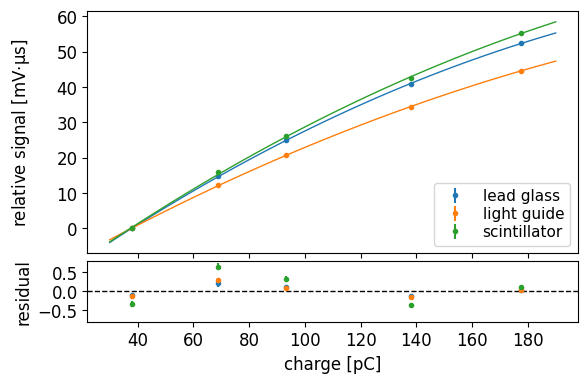

In [14]:
chargesFit = np.linspace(30, 190)

with plt.rc_context(regu):

    fig, ax = plt.subplots(2,1,sharex=True,gridspec_kw={'height_ratios':[4,1]})

    for c,label in enumerate(labels):
        odrOutput = ODR(RealData(x=charges[0], y=integral[c,0], sy=integral[c,1], sx=charges[1]), Model(chargeFct), beta0=[1.,1.,1.,1.], ifixb=[1,1,1,0]).run()
        popt = odrOutput.beta; perr = odrOutput.sd_beta
        ax[0].errorbar(charges[0], integral[c,0]-integral[c,0,0], integral[c,1], fmt=f'C{c}.', label=label)
        ax[0].errorbar(chargesFit, chargeFct(popt, chargesFit)-integral[c,0,0], fmt=f'C{c}-', lw=1)
        ax[1].errorbar(charges[0], integral[c,0]-chargeFct(popt, charges[0]), integral[c,1], charges[1], fmt=f'C{c}.')

    ax[1].axhline(0, c='C5', ls='--', lw=1)
    ax[0].legend(loc='lower right')
    ax[0].set(ylabel=r'relative signal [mV$\cdot$µs]')
    ax[1].set(xlabel='charge [pC]', ylabel='residual', ylim=(-0.8, 0.8))
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    fig.align_ylabels(ax)
        
    plt.show()    

### Charge Calibration

In [15]:
# beam energy in [Mev]
energy_03 = 1020.2

runs = [219, 220, 222, 223, 224, 225, 227]

charges = np.zeros((2, len(runs)))
integral = np.zeros((nPMT, 2, len(runs)))

for r,run in enumerate(runs):

    charges[:,r] = meanWithError(getDOOCS(run, type='charge'))
    
    for ch in chPMT:
        integral[ch,:,r] = meanWithError(getCALO(run, ch, 'int'))

chmn = [2,6]
integral = np.array([(integral[chmn[0],0]+integral[chmn[1],0])/2, np.sqrt(integral[chmn[0],1]**2+integral[chmn[1],1]**2)/2])

charges_03 = charges
integral_03 = integral

In [16]:
# beam energy in [MeV]
energy_04 = 1200

# Runs
runs = [307, 306, 305, 304, 303]

charges = np.zeros((2, len(runs)))
integral = np.zeros((nPMT, 2, len(runs)))

# get charge and calorimeter data
for r,run in enumerate(runs):
    
    charges[:,r] = meanWithError(getDOOCS(run, type='charge'))

    for ch in chPMT:
        integral[ch,:,r] = meanWithError(getCALO(run, ch, 'int'))

integral = np.array([(integral[chmn[0],0]+integral[chmn[1],0])/2, np.sqrt(integral[chmn[0],1]**2+integral[chmn[1],1]**2)/2])

charges_04 = charges
integral_04 = integral

#### Energy Compensation

In [17]:
fitFct = lambda x, p0, p1, p2, Ce=1: Ce * (p2*x*x + p1*x + p0)

In [18]:
# fit the calibration data (March 2024) with the charge function and the energy constant C_E = 1
odrOutput = ODR(RealData(x=charges_03[0], y=integral_03[0], sy=integral_03[1], sx=charges_03[1]), Model(chargeFct), beta0=[1.,1.,1.,1.], ifixb=[1,1,1,0]).run()
popt = odrOutput.beta; perr = odrOutput.sd_beta
odrOutput.pprint()

Beta: [ 1.99022518e+01  4.26048112e-01 -6.10515710e-04  1.00000000e+00]
Beta Std Error: [4.64702561e-01 1.38192674e-02 5.86945626e-05 0.00000000e+00]
Beta Covariance: [[ 6.82504113e-03 -1.75999049e-04  7.01883036e-07  0.00000000e+00]
 [-1.75999049e-04  6.03566576e-06 -2.54933583e-08  0.00000000e+00]
 [ 7.01883036e-07 -2.54933583e-08  1.08880695e-10  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Residual Variance: 31.640610801812507
Inverse Condition #: 5.146657834988412e-06
Reason(s) for Halting:
  Sum of squares convergence


In [19]:
# perform a Monte Carlo based uncertainty propagation to find the energy constant for the validation data (April 2024)
N_MC = 10000
N_Meas = len(charges_04[0])
iCal = np.identity(N_Meas, dtype=bool)
energyCal = np.zeros((N_Meas, 2))

for i in range(N_Meas):

    mcParams = np.array([np.random.normal(charges_04[0][iCal[i]], charges_04[1][iCal[i]], N_MC), 
                         np.random.normal(integral_04[0][iCal[i]], integral_04[1][iCal[i]], N_MC), 
                         np.random.normal(popt[0], perr[0], N_MC), 
                         np.random.normal(popt[1], perr[1], N_MC), 
                         np.random.normal(popt[2], perr[2], N_MC)]).T

    OPT = np.empty(N_MC)
    for n_mc in range(N_MC):
        popt_cal, _ = curve_fit(lambda x, p3: chargeFct([*mcParams[n_mc,2:],p3], x), [mcParams[n_mc,0]], [mcParams[n_mc,1]], p0=(1))
        OPT[n_mc] = popt_cal[0]

    energyCal[i] = OPT.mean(), OPT.std()
    print(f'{charges_04[0,i]:3.0f} pC: {energyCal[i,0]:.02f} +/- {energyCal[i,1]:.02f}')

/var/folders/1r/1tyjjhy95gxfb74qcm8bdf200000gn/T/ipykernel_25347/130792229.py:17: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_cal, _ = curve_fit(lambda x, p3: chargeFct([*mcParams[n_mc,2:],p3], x), [mcParams[n_mc,0]], [mcParams[n_mc,1]], p0=(1))


 38 pC: 1.08 +/- 0.02
 69 pC: 1.09 +/- 0.03
 93 pC: 1.08 +/- 0.03
138 pC: 1.07 +/- 0.04
177 pC: 1.08 +/- 0.04


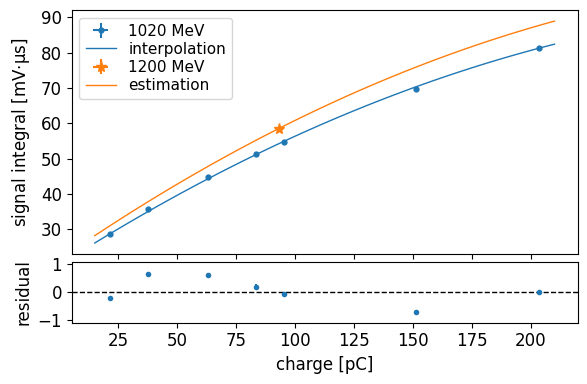

In [20]:
chargesFit = np.linspace(15, 210)

with plt.rc_context(regu):

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[4,1]})
    
    ax[0].errorbar(charges_03[0], *integral_03, charges_03[1], fmt='C0.', ms=7, label='1020 MeV')
    ax[0].errorbar(chargesFit, chargeFct(popt, chargesFit), fmt='C0-', lw=1, label='interpolation')

    ax[1].errorbar(charges_03[0], integral_03[0]-chargeFct(popt, charges_03[0]), integral_03[1], charges_03[1], fmt='C0.')
    ax[1].axhline(0, c='C5', ls='--', lw=1)
    
    for i in [2]:
        ax[0].errorbar(charges_04[0,i], integral_04[0,i], integral_04[1,i], charges_04[1,i], fmt='C1*', ms=8, label='1200 MeV')
        ax[0].errorbar(chargesFit, energyCal[i,0]*chargeFct(popt, chargesFit), fmt='C1-', lw=1, label='estimation')
    
    ax[0].legend()
    ax[0].set(ylabel=r'signal integral [mV$\cdot$µs]')
    ax[1].set(xlabel='charge [pC]', ylabel='residual', ylim=(-1.1, 1.1))

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    fig.align_ylabels(ax)
    
    plt.show()

In [21]:
N_MC = 10000

chargeEst = np.zeros((2, N_Meas, len(integral_04[0,~iCal[i]])))

for i in range(N_Meas):

    for j,i04 in enumerate(zip(*integral_04[:,~iCal[i]])):
        
        mcParams = np.array([np.random.normal(*i04, N_MC), 
                             np.random.normal(popt[0], perr[0], N_MC), 
                             np.random.normal(popt[1], perr[1], N_MC), 
                             np.random.normal(popt[2], perr[2], N_MC), 
                             np.random.normal(*energyCal[i], N_MC)]).T
    
        OPT = np.empty(N_MC)
        for n_mc in range(N_MC):
            opt = root(lambda q0: mcParams[n_mc,0] - chargeFct(mcParams[n_mc,1:], q0), x0=100)
            OPT[n_mc] = opt.x[0]
        
        chargeEst[:,i,j] = OPT.mean(), OPT.std()

reference charge: 93 pC

precision
  38 pC: +8.3%
  69 pC: +7.1%
 138 pC: +8.5%
 177 pC: +11.6%

accuracy
  38 pC: +1.3%
  69 pC: +1.5%
 138 pC: -0.5%
 177 pC: +0.8%

significance
  38 pC: +0.2σ
  69 pC: +0.2σ
 138 pC: -0.1σ
 177 pC: +0.1σ


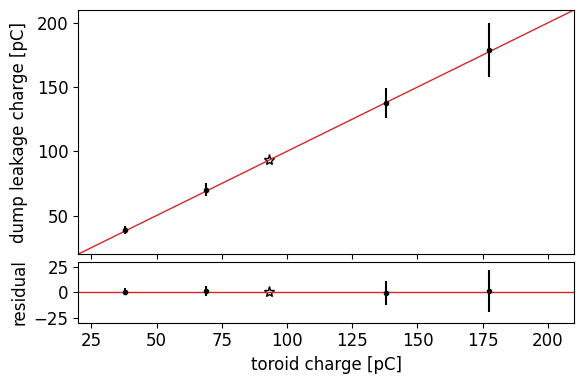

In [22]:
i = 2

print(f'reference charge: {charges_04[0,i]:.0f} pC')

# relative precision in [%]
relPrec = 1e2 * chargeEst[1,i] / chargeEst[0,i]
print('\nprecision')
print('\n'.join('{:4.0f} pC: {:+.1f}%'.format(Q,D) for Q,D in zip(charges_04[0,~iCal[i]], relPrec)))

# relative accuract in [%]
relAcc = 1e2 * (chargeEst[0,i]-charges_04[0,~iCal[i]]) / charges_04[0,~iCal[i]]
print('\naccuracy')
print('\n'.join('{:4.0f} pC: {:+.1f}%'.format(Q,D) for Q,D in zip(charges_04[0,~iCal[i]], relAcc)))

# significance of difference in [sigma]
relDiff = (chargeEst[0,i]-charges_04[0,~iCal[i]]) / np.sqrt(chargeEst[1,i]**2+charges_04[1,~iCal[i]]**2)
print('\nsignificance')
print('\n'.join('{:4.0f} pC: {:+.1f}σ'.format(Q,D) for Q,D in zip(charges_04[0,~iCal[i]], relDiff)))

chargeEq = np.linspace(10, 220)

with plt.rc_context(regu):

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios':[4,1]})
    
    ax[0].errorbar(charges_04[0,~iCal[i]], chargeEst[0,i], chargeEst[1,i], charges_04[1,~iCal[i]], fmt='C5.')
    ax[0].plot(charges_04[0,iCal[i]], charges_04[0,iCal[i]], 'C5*', ms=8, fillstyle='none')
    ax[0].plot(chargeEq, chargeEq, 'C3-', lw=1)
    ax[0].set(ylabel='dump leakage charge [pC]', ylim=(20,210))
    
    ax[1].errorbar(charges_04[0,~iCal[i]], chargeEst[0,i]-charges_04[0,~iCal[i]], chargeEst[1,i], fmt='C5.')
    ax[1].plot(charges_04[0,iCal[i]], 0, 'C5*', ms=8, fillstyle='none')
    ax[1].axhline(0, c='C3', ls='-', lw=1)
    ax[1].set(xlabel='toroid charge [pC]', ylabel='residual', xlim=(20,210), ylim=(-30,30))
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    fig.align_ylabels(ax)
    plt.show()

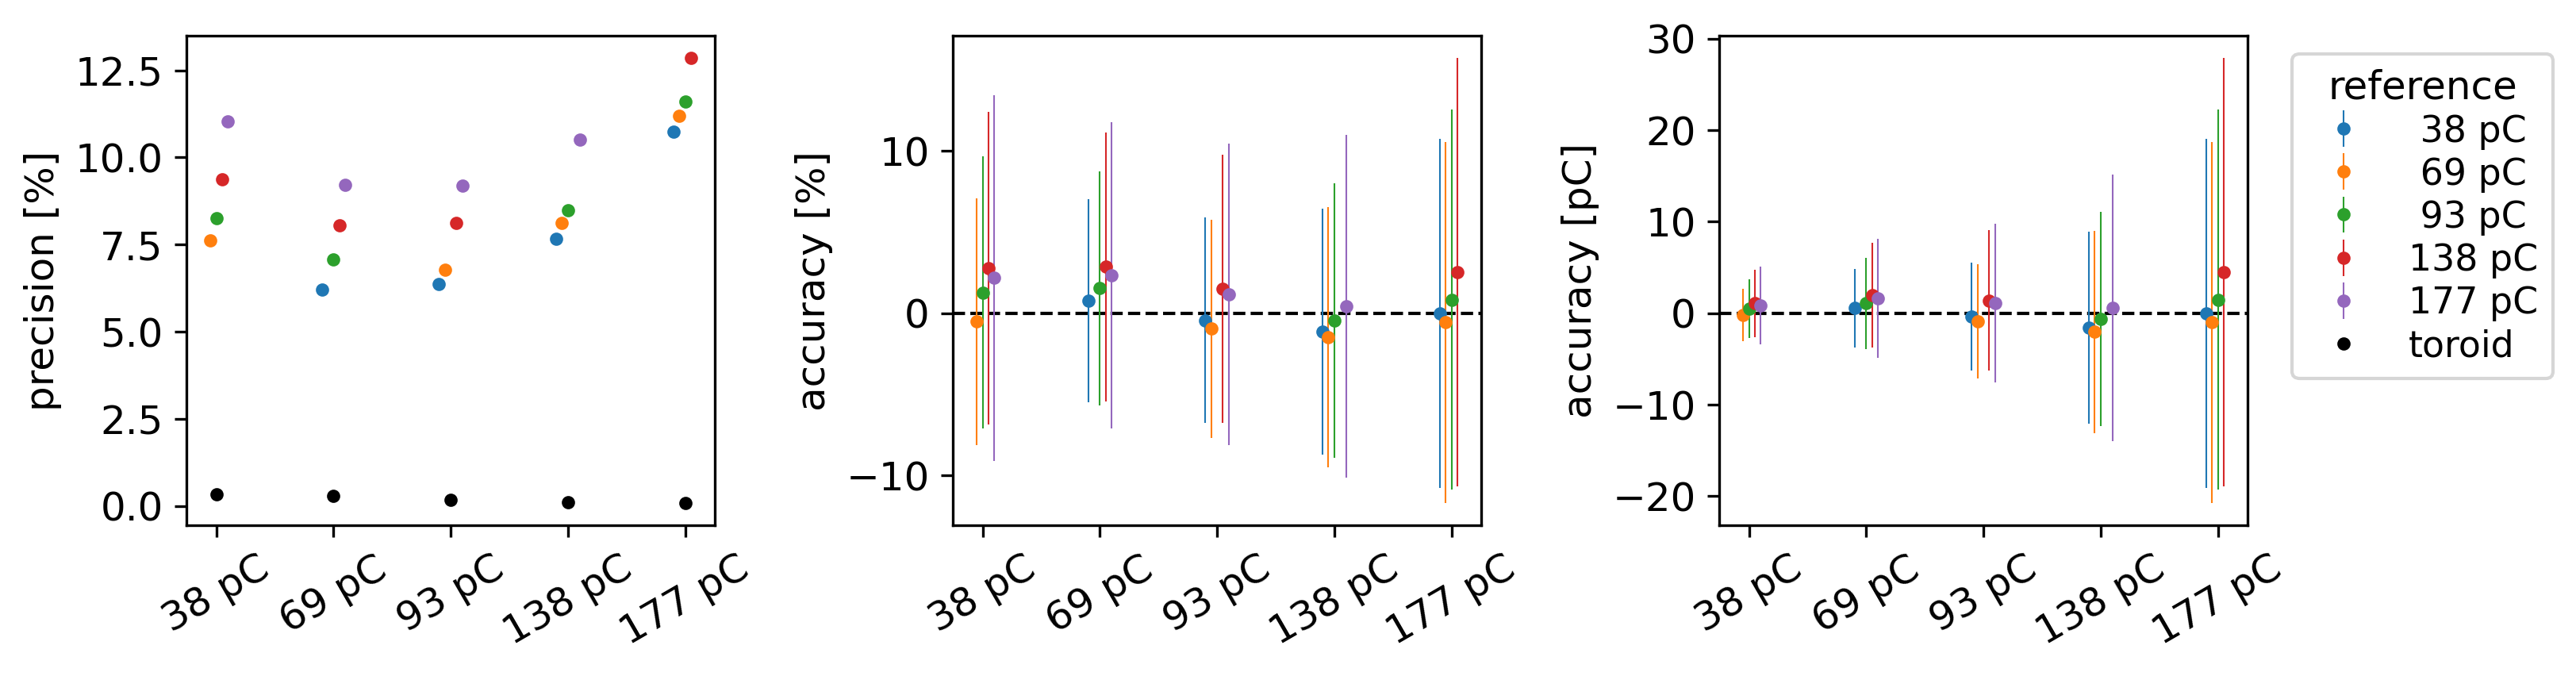

In [23]:
with plt.rc_context(post):

    fig, ax = plt.subplots(1, 3, figsize=(11,3))

    # toroid precision and reference linees
    ax[0].errorbar(np.arange(N_Meas), 1e2*charges_04[1]/charges_04[0], fmt='C5.')
    ax[1].axhline(0, c='C5', ls='--', lw=1)
    ax[2].axhline(0, c='C5', ls='--', lw=1)

    for i in range(N_Meas):

        xtcks = np.arange(N_Meas)[~iCal[i]]+0.05*(i+1)-0.15

        # relative precision (sigma_Q / Q)
        relPrec = 1e2 * chargeEst[1,i] / chargeEst[0,i]
        
        # relative accuracy ((Q - Q_toroid) / Q_toroid)
        relAcc = [1e2 * (chargeEst[0,i]-charges_04[0,~iCal[i]]) / charges_04[0,~iCal[i]], 
                  1e2 * np.sqrt(chargeEst[1,i]**2/charges_04[0,~iCal[i]]**2 + chargeEst[0,i]**2*charges_04[1,~iCal[i]]**2/charges_04[0,~iCal[i]]**4)]
        
        # absolute accuracy (Q - Q_toroid)
        absAcc = [chargeEst[0,i]-charges_04[0,~iCal[i]], 
                  np.sqrt(chargeEst[1,i]**2+charges_04[1,~iCal[i]]**2)]

        ax[0].errorbar(xtcks, relPrec, fmt='.')    
        ax[1].errorbar(xtcks, *relAcc, fmt='.', lw=0.5)
        ax[2].errorbar(xtcks, *absAcc, fmt='.', lw=0.5, label=f'{charges_04[0,i]:3.0f} pC')

    # format the plots
    for a in ax:
        a.set_xticks(np.arange(len(charges_04[0])), labels=['{:.0f} pC'.format(Q) for Q in charges_04[0]], rotation=30)
    ax[0].set(ylabel='precision [%]', xticks=(np.arange(N_Meas)))
    ax[1].set(ylabel='accuracy [%]', xticks=(np.arange(N_Meas)))
    ax[2].set(ylabel='accuracy [pC]', xticks=(np.arange(N_Meas)))

    # create the legend
    ax[2].errorbar(np.nan, np.nan, fmt='C5.', label='toroid')
    ax[2].legend(loc='upper left', title='reference', bbox_to_anchor=(1.05,1))
    
    fig.tight_layout()
    plt.show()

## Comparison Electrons / Photons

In [24]:
# actual bunch charge [pC]
qBX = 100e-12

# number of particles in a bunch
nBX = qBX / elementary_charge

# number of simulated particles
nSimPart = 1e5

# scaling factor
scaling = nBX / nSimPart

In [25]:
# load the pre-processed data set
df = pd.read_csv('processed/g4bl_simulationData.csv')

# simulated energies in [GeV]
Energy = sorted(set(df['energy_GeV']))

In [26]:
edep_electron = np.zeros((2,len(Energy)))
edep_photon = np.zeros((2,len(Energy)))

for i,energy in enumerate(Energy):

    # load the electron data
    mask = (df['particle']=='electron') & (df['energy_GeV']==energy)
    edep = df[mask]['Edep_GeV']
    edep_electron[:,i] = edep.mean(), edep.std()

    # load the photon data
    mask = (df['particle']=='photon') & (df['energy_GeV']==energy)
    edep = df[mask]['Edep_GeV']
    edep_photon[:,i] = edep.mean(), edep.std()

# scale the deposited energy to a full bunch crossing and convert to [TeV]
edep_electron = scaling * edep_electron / 1e3
edep_photon = scaling * edep_photon / 1e3

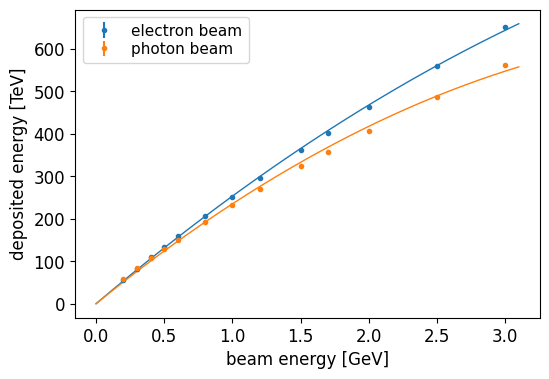

In [27]:
eFit = np.linspace(0, 3.1, 1001)

fig, ax = plt.subplots()

popt, pcov = curve_fit(lambda x, p1, p2: quadFct([0, p1, p2], x), Energy, edep_electron[0], sigma=edep_electron[1], absolute_sigma=True, p0=(1,1))
perr = np.sqrt(np.diag(pcov))
ax.errorbar(Energy, *edep_electron, fmt='C0.', label='electron beam')
ax.plot(eFit, quadFct([0,*popt], eFit), 'C0-', lw=1)

popt, pcov = curve_fit(lambda x, p1, p2: quadFct([0, p1, p2], x), Energy, edep_photon[0], sigma=edep_photon[1], absolute_sigma=True, p0=(1,1))
perr = np.sqrt(np.diag(pcov))
ax.errorbar(Energy, *edep_photon, fmt='C1.', label='photon beam')
ax.plot(eFit, quadFct([0,*popt], eFit), 'C1-', lw=1)

ax.legend()
ax.set(xlabel='beam energy [GeV]', ylabel='deposited energy [TeV]')

plt.show()

In [28]:
edep_diff = edep_electron[0]-edep_photon[0], np.sqrt(edep_electron[1]**2+edep_photon[1]**2)
Significance = abs(edep_diff[0]/edep_diff[1])

for e, s in zip(Energy, Significance):
    print(f'{e} GeV: {s:4.1f}σ')

0.2 GeV:  0.4σ
0.3 GeV:  0.2σ
0.4 GeV:  0.6σ
0.5 GeV:  1.6σ
0.6 GeV:  2.4σ
0.8 GeV:  4.0σ
1.0 GeV:  4.5σ
1.2 GeV:  5.9σ
1.5 GeV:  7.1σ
1.7 GeV:  8.1σ
2.0 GeV: 10.4σ
2.5 GeV:  9.5σ
3.0 GeV: 14.2σ
